# Keyword Graph
The aim of this notebook is to generate the most accurate graph from author keywords in the ACM 2017 periodicals dataset.

In [1]:
import fasttext
import fasttext.util
import pandas as pd
import numpy as np
import pickle
import networkx as nx
import matplotlib.pyplot as plt

from Scripts.graphgeneration import BuildRelationList, BuildGraphDictFromRelationList, gbm_classifier, PlotGraph, PlotGraphs
from Scripts.util import cartesianProductOfLists, ExtractIntLabelFromPred

[nltk_data] Downloading package wordnet to /home/jcl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jcl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Loading Data

In [2]:
kw_df = pd.read_csv("Data/keywords_preprocessed.csv")
kw_df.head()

,Keywords,Occurences
0,archiving,6
1,collaboration,99
2,copyright,7
3,journal policy,2
4,preprints,2


## Loading models

In [3]:
model = fasttext.load_model('Models/Trained_FastText_model.bin')

In [4]:
ft_model = fasttext.load_model('Models/cc.en.300.bin')

In [5]:
gbm_model1 = pickle.load(open("Models/naive_gridsearch_classifier.pkl", "rb"))
gbm_model1

GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=20, min_samples_split=20,
                           n_estimators=900, random_state=10, subsample=0.8)

In [6]:
gbm_model2 = pickle.load(open("Models/naive_gridsearch_01_classifier.pkl", "rb"))
gbm_model2

GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=20, min_samples_split=20,
                           n_estimators=900, random_state=10, subsample=0.8)

## Generating the Keyword graph for each model

### Trimming the keywords set by occurences and generating pairs

In [10]:
## Removing less interesting keywords
kw_df_trimmed = kw_df[(kw_df.Occurences > 70)]
kw_df_trimmed.Keywords = kw_df_trimmed.Keywords.apply(str)# There are floats in the data, maybe take care of them ???
kw_df_trimmed.describe()

/tmp/ipykernel_1730/1499938009.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kw_df_trimmed.Keywords = kw_df_trimmed.Keywords.apply(str)# There are floats in the data, maybe take care of them ???


,Occurences
count,188.000000
mean,133.984043
std,73.891775
min,71.000000
25%,80.750000
50%,107.500000
75%,165.500000
max,479.000000


In [11]:
## Generating the possible keyword pairs
nodes = kw_df_trimmed.Keywords.to_numpy()
kw_pairs = cartesianProductOfLists(nodes, nodes)

In [12]:
kw_pairs[:10]

[('collaboration', 'collaboration'),
 ('collaboration', 'education'),
 ('collaboration', 'reliability'),
 ('collaboration', 'usability'),
 ('collaboration', 'communication'),
 ('collaboration', 'protocol'),
 ('collaboration', 'user interface'),
 ('collaboration', 'xml'),
 ('collaboration', 'design'),
 ('collaboration', 'learning')]

### Using the GBM -1, 0, 1 Classifier

In [13]:
relationList = BuildRelationList(kw_pairs, kw_pairs, lambda x: gbm_classifier(ft_model.get_sentence_vector, gbm_model1.predict, x))

gbm1G = nx.DiGraph(BuildGraphDictFromRelationList(relationList))

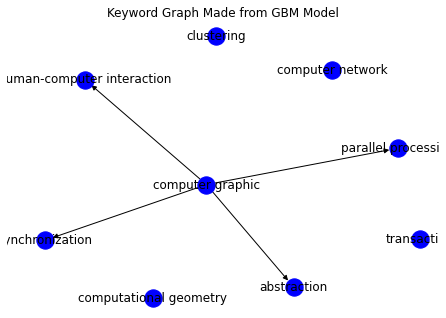

In [17]:
## Show subgraphs
PlotGraph(nodes, gbm1G, starting_node=10, num_nodes=19, title="Keyword Graph Made from GBM Model")

### Using the GBM 0, 1 Classifier

In [18]:
relationList = BuildRelationList(kw_pairs, kw_pairs, lambda x: gbm_classifier(ft_model.get_sentence_vector, gbm_model2.predict, x))

gbm2G = nx.DiGraph(BuildGraphDictFromRelationList(relationList))

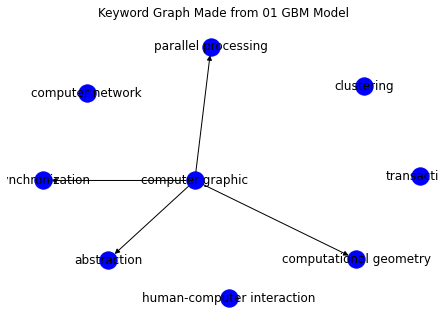

In [19]:
## Show subgraphs
PlotGraph(nodes, gbm2G, starting_node=10, num_nodes=19, title="Keyword Graph Made from 01 GBM Model")

### Using the FastText -1, 0, 1 classifier

In [20]:
relationList = BuildRelationList(kw_pairs, [", ".join(pair) for pair in kw_pairs], lambda x: ExtractIntLabelFromPred(model.predict(x)))

ftG = nx.DiGraph(BuildGraphDictFromRelationList(relationList))

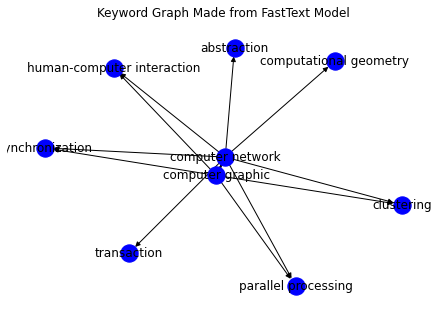

In [21]:
PlotGraph(nodes, ftG, starting_node=10, num_nodes=19, title="Keyword Graph Made from FastText Model")

## Number of connected components for each graph

In [22]:
## Get the weakly connected components of the directed graphs:
gbm1_comp = list(nx.weakly_connected_components(gbm1G))
gbm2_comp = list(nx.weakly_connected_components(gbm2G))
ft_comp   = list(nx.weakly_connected_components(ftG))

In [24]:
## Python program to print the data
print ("{:<20} {:<20} {:<20} {:<20}".format('','GBM1 Graph','GBM2 Graph', 'FastText Graph'))
print ("{:<20} {:<20} {:<20} {:<20}".format("Number of weakly cc", len(gbm1_comp), len(gbm2_comp), len(ft_comp)))

                     GBM1 Graph           GBM2 Graph           FastText Graph      
Number of weakly cc  1                    1                    1                   


In [25]:
print("Total number of nodes:", len(nodes))

Total number of nodes: 188


In [27]:
print("Number of queries:", len(nodes)**2-len(nodes))

Number of queries: 35156
